# Tracing Executions

In this chapter, we show how to _observe program state during an execution_ – a prerequisite for logging and interactive debugging. Thanks to the power of Python, we can do this in a few lines of code.

In [1]:
from bookutils import YouTubeVideo
YouTubeVideo("UYAvCl-5NGY")

**Prerequisites**

* You should have read the [Introduction to Debugging](Intro_Debugging.ipynb).
* Knowing a bit of _Python_ is helpful for understanding the code examples in the book.

In [2]:
import bookutils

In [3]:
from bookutils import quiz

In [4]:
import Intro_Debugging

## Synopsis
<!-- Automatically generated. Do not edit. -->

To [use the code provided in this chapter](Importing.ipynb), write

```python
>>> from debuggingbook.Tracer import <identifier>
```

and then make use of the following features.


This chapter provides a `Tracer` class that allows to log events during program execution. The advanced subclass `EventTracer` allows to restrict logs to specific conditions. Logs are shown only while the given `condition` holds:

```python
>>> with EventTracer(condition='line == 223 or len(out) >= 6'):
>>>     remove_html_markup('<b>foo</b>bar')
...
                                         # s = '<b>foo</b>bar', function = 'remove_html_markup', line = 243, tag = False, quote = False, out = 'foobar', c = 'r'
243     for c in s:
                                         # line = 255
255     return out
remove_html_markup() returns 'foobar'

```
It also allows to restrict logs to specific events. Log entries are shown only if one of the given `events` changes its value:

```python
>>> with EventTracer(events=["c == '/'"]):
>>>     remove_html_markup('<b>foo</b>bar')
...
Calling remove_html_markup(s = '<b>foo</b>bar', function = 'remove_html_markup', line = 238)
...
                                         # line = 244, tag = False, quote = False, out = '', c = '<'
244         assert tag or not quote
...
                                         # tag = True, out = 'foo', c = '/'
244         assert tag or not quote
...
                                         # c = 'b'
244         assert tag or not quote

```
`Tracer` and `EventTracer` classes allow for subclassing and further customization.

![](PICS/Tracer-synopsis-1.svg)



## Tracing Python Programs

How do debugging tools access the state of a program during execution? For _interpreted_ languages such as Python, this is a simple task. If a language is interpreted, it is typically fairly easy to control execution and to inspect state – since this is what the interpreter is doing already anyway. Debuggers are then implemented on top of _hooks_ that allow to interrupt execution and access program state.

Python makes such a hook available in the function `sys.settrace()`. You invoke it with a *tracing function* that will be called at every line executed, as in

```python
sys.settrace(traceit)
```

Such a tracing function is convenient, as it simply traces _everything_. In contrast to an interactive debugger, where you have to select which aspect of the execution you're interested in, you can just print out a long trace into an *execution log*, to examine it later.

This tracing function takes the format

In [5]:
from types import FrameType, TracebackType

In [6]:
# ignore
from typing import Any, Optional, Callable, Dict, List, Type, TextIO, cast

In [7]:
def traceit(frame: FrameType, event: str, arg: Any) -> Optional[Callable]:
    ...

Here, `event` is a string telling what has happened in the program – for instance,

* `'line'` – a new line is executed
* `'call'` – a function just has been called
* `'return'` – a function returns

The `frame` argument holds the current execution frame – that is, the function and its local variables:

* `frame.f_lineno` – the current line
* `frame.f_locals` – the current variables (as a Python dictionary)
* `frame.f_code` – the current code (as a Code object), with attributes such as
    * `frame.f_code.co_name` – the name of the current function

We can thus get a *trace* of the program by simply printing out these values:

In [8]:
def traceit(frame: FrameType, event: str, arg: Any) -> Optional[Callable]:  # type: ignore
    print(event, frame.f_lineno, frame.f_code.co_name, frame.f_locals)

The return value of the trace function is the function to be executed at the next event – typically, this is the function itself:

In [9]:
def traceit(frame: FrameType, event: str, arg: Any) -> Optional[Callable]:  # type: ignore
    print(event, frame.f_lineno, frame.f_code.co_name, frame.f_locals)
    return traceit

Let us try this out on the `remove_html_markup()` function introduced in the [Introduction to Debugging](Intro_Debugging.ipynb):

In [10]:
from Intro_Debugging import remove_html_markup

In [11]:
import inspect

In [12]:
from bookutils import print_content

In [13]:
content, start_line_number = inspect.getsourcelines(remove_html_markup)
print_content(content="".join(content).strip(), filename='.py', start_line_number=start_line_number)

238  def remove_html_markup(s):  # type: ignore
239      tag = False
240      quote = False
241      out = ""
242  
243      for c in s:
244          assert tag or not quote
245  
246          if c == '<' and not quote:
247              tag = True
248          elif c == '>' and not quote:
249              tag = False
250          elif (c == '"' or c == "'") and tag:
251              quote = not quote
252          elif not tag:
253              out = out + c
254  
255      return out

We define a variant `remove_html_markup_traced()` which turns on tracing, invokes `remove_html_markup()`, and turns tracing off again.

In [14]:
import sys

In [15]:
def remove_html_markup_traced(s):  # type: ignore
    sys.settrace(traceit)
    ret = remove_html_markup(s)
    sys.settrace(None)
    return ret

Here is what we get when we run `remove_html_markup_traced()`:
* We first get a `call` event (showing the call of `remove_html_markup()`)
* We then get various `line` events (for each line of `remove_html_markup()`)
* In the end, we get a `return` event (showing the return from `remove_html_markup()`)

In [16]:
remove_html_markup_traced('xyz')

call 238 remove_html_markup {'s': 'xyz'}
line 239 remove_html_markup {'s': 'xyz'}
line 240 remove_html_markup {'s': 'xyz', 'tag': False}
line 241 remove_html_markup {'s': 'xyz', 'tag': False, 'quote': False}
line 243 remove_html_markup {'s': 'xyz', 'tag': False, 'quote': False, 'out': ''}
line 244 remove_html_markup {'s': 'xyz', 'tag': False, 'quote': False, 'out': '', 'c': 'x'}
line 246 remove_html_markup {'s': 'xyz', 'tag': False, 'quote': False, 'out': '', 'c': 'x'}
line 248 remove_html_markup {'s': 'xyz', 'tag': False, 'quote': False, 'out': '', 'c': 'x'}
line 250 remove_html_markup {'s': 'xyz', 'tag': False, 'quote': False, 'out': '', 'c': 'x'}
line 252 remove_html_markup {'s': 'xyz', 'tag': False, 'quote': False, 'out': '', 'c': 'x'}
line 253 remove_html_markup {'s': 'xyz', 'tag': False, 'quote': False, 'out': '', 'c': 'x'}
line 243 remove_html_markup {'s': 'xyz', 'tag': False, 'quote': False, 'out': 'x', 'c': 'x'}
line 244 remove_html_markup {'s': 'xyz', 'tag': False, 'quote': F

'xyz'

During the execution, we also see all local _variables_. As `remove_html_markup()` is called at the very beginning, the parameter `s` holds the argument `"xyz"`. As more local variables are being assigned, these show up in our dictionary of local variables.

We see how the variable `c` takes one character of the input string at a time; the `out` variable accumulates them.  and the `tag` and `quote` flags stay unchanged throughout the execution.

An interesting aspect is that we can actually _access_ all these local variables as regular Python objects. We can, for instance, separately access the value of `c` by looking up `frame.f_locals['c']`:

In [17]:
def traceit(frame: FrameType, event: str, arg: Any) -> Optional[Callable]:  # type: ignore
    if 'c' in frame.f_locals:
        value_of_c = frame.f_locals['c']
        print(f"{frame.f_lineno:} c = {repr(value_of_c)}")
    else:
        print(f"{frame.f_lineno:} c is undefined")

    return traceit

This allows us to specifically monitor individual variables:

In [18]:
remove_html_markup_traced('xyz')

238 c is undefined
239 c is undefined
240 c is undefined
241 c is undefined
243 c is undefined
244 c = 'x'
246 c = 'x'
248 c = 'x'
250 c = 'x'
252 c = 'x'
253 c = 'x'
243 c = 'x'
244 c = 'y'
246 c = 'y'
248 c = 'y'
250 c = 'y'
252 c = 'y'
253 c = 'y'
243 c = 'y'
244 c = 'z'
246 c = 'z'
248 c = 'z'
250 c = 'z'
252 c = 'z'
253 c = 'z'
243 c = 'z'
255 c = 'z'
255 c = 'z'


'xyz'

This tracing capability is tremendously powerful – actually, it is one of the reasons this book uses Python all over the place. In most other languages, inspecting the program state during execution is much more complex than the handful of lines we have needed so far.

To learn more about `sys.settrace()`, spend a moment to look up [its documentation in the Python reference](https://docs.python.org/3/library/sys.html).

In [19]:
# ignore
import math

In [20]:
quiz("What happens if the tracing function returns `None` while tracing function `f()`?"
     " (You can also try this out yourself.)",
     [
         'Tracing stops for all functions;'
         ' the tracing function is no longer called',
         'Tracing stops for `f()`: the tracing function is called when `f()` returns',
         'Tracing stops for `f()` the rest of the execution: the tracing function'
         ' is no longer called for calls to `f()`',
         'Nothing changes'
     ], "int(math.log(7.38905609893065))", globals())

Indeed, as listed in the documentation: if `sys.settrace()` returns `None`, then tracing stops for the current scope; tracing will resume when the current function returns. This can be helpful for momentarily disable (expensive) tracing.

## A Tracer Class

Let us refine our tracing function a bit. First, it would be nice if one could actually _customize_ tracing just as needed. To this end, we introduce a `Tracer` class that does all the formatting for us, and which can be _subclassed_ to allow for different output formats.

The `traceit()` method in `Tracer` is the same as above, and again is set up via `sys.settrace()`. It uses a `log()` method after the Python `print()` function.

The typical usage of `Tracer`, however, is as follows:

```python
with Tracer():
    # Code to be traced
    ...

# Code no longer traced
...
```

When the `with` statement is encountered, the `__enter__()` method is called, which starts tracing. When the `with` block ends, the `__exit__()` method is called, and tracing is turned off. We take special care that the internal `__exit__()` method is not part of the trace, and that any other tracing function that was active before is being restored.

We build `Tracer` on top of a class named `StackInspector`, whose `our_frame()` and `is_internal_error()` methods us with providing better diagnostics in case of error.

In [21]:
from StackInspector import StackInspector

In [22]:
class Tracer(StackInspector):
    """A class for tracing a piece of code. Use as `with Tracer(): block()`"""

    def __init__(self, *, file: TextIO = sys.stdout) -> None:
        """Trace a block of code, sending logs to `file` (default: stdout)"""
        self.original_trace_function: Optional[Callable] = None
        self.file = file

    def traceit(self, frame: FrameType, event: str, arg: Any) -> None:
        """Tracing function. To be overridden in subclasses."""
        self.log(event, frame.f_lineno, frame.f_code.co_name, frame.f_locals)

    def _traceit(self, frame: FrameType, event: str, arg: Any) -> Optional[Callable]:
        """Internal tracing function."""
        if self.our_frame(frame):
            # Do not trace our own methods
            pass
        else:
            self.traceit(frame, event, arg)
        return self._traceit

    def log(self, *objects: Any, 
            sep: str = ' ', end: str = '\n', 
            flush: bool = True) -> None:
        """
        Like `print()`, but always sending to `file` given at initialization,
        and flushing by default.
        """
        print(*objects, sep=sep, end=end, file=self.file, flush=flush)

    def __enter__(self) -> Any:
        """Called at begin of `with` block. Turn tracing on."""
        self.original_trace_function = sys.gettrace()
        sys.settrace(self._traceit)

        # This extra line also enables tracing for the current block
        # inspect.currentframe().f_back.f_trace = self._traceit
        return self

    def __exit__(self, exc_tp: Type, exc_value: BaseException, 
                 exc_traceback: TracebackType) -> Optional[bool]:
        """
        Called at end of `with` block. Turn tracing off.
        Return `None` if ok, not `None` if internal error.
        """
        sys.settrace(self.original_trace_function)

        # Note: we must return a non-True value here,
        # such that we re-raise all exceptions
        if self.is_internal_error(exc_tp, exc_value, exc_traceback):
            return False  # internal error
        else:
            return None  # all ok

Here's how we use the `Tracer` class. You see that everything works as before, except that it is nicer to use:

In [23]:
with Tracer():
    remove_html_markup("abc")

call 238 remove_html_markup {'s': 'abc'}
line 239 remove_html_markup {'s': 'abc'}
line 240 remove_html_markup {'s': 'abc', 'tag': False}
line 241 remove_html_markup {'s': 'abc', 'tag': False, 'quote': False}
line 243 remove_html_markup {'s': 'abc', 'tag': False, 'quote': False, 'out': ''}
line 244 remove_html_markup {'s': 'abc', 'tag': False, 'quote': False, 'out': '', 'c': 'a'}
line 246 remove_html_markup {'s': 'abc', 'tag': False, 'quote': False, 'out': '', 'c': 'a'}
line 248 remove_html_markup {'s': 'abc', 'tag': False, 'quote': False, 'out': '', 'c': 'a'}
line 250 remove_html_markup {'s': 'abc', 'tag': False, 'quote': False, 'out': '', 'c': 'a'}
line 252 remove_html_markup {'s': 'abc', 'tag': False, 'quote': False, 'out': '', 'c': 'a'}
line 253 remove_html_markup {'s': 'abc', 'tag': False, 'quote': False, 'out': '', 'c': 'a'}
line 243 remove_html_markup {'s': 'abc', 'tag': False, 'quote': False, 'out': 'a', 'c': 'a'}
line 244 remove_html_markup {'s': 'abc', 'tag': False, 'quote': F

## Accessing Source Code

We can now go and _extend_ the class with additional features. It would be nice if it could actually display the source code of the function being tracked, such that we know where we are. In Python, the function `inspect.getsource()` returns the source code of a function or module. Looking up

```python
module = inspect.getmodule(frame.f_code)
```

gives us the current module, and

```python
inspect.getsource(module)
```

gives us its source code. All we then have to do is to retrieve the current line.

To implement our extended `traceit()` method, we use a bit of a hack. The Python language requires us to define an entire class with all methods as a single, continuous unit; however, we would like to introduce one method after another.  To avoid this problem, we use a special hack: Whenever we want to introduce a new method to some class `C`, we use the construct

```python
class C(C):
    def new_method(self, args):
        pass
```

This seems to define `C` as a subclass of itself, which would make no sense – but actually, it introduces a new `C` class as a subclass of the _old_ `C` class, and then shadowing the old `C` definition.  What this gets us is a `C` class with `new_method()` as a method, which is just what we want.  (`C` objects defined earlier will retain the earlier `C` definition, though, and thus must be rebuilt.)

Using this hack, we can now redefine the `traceit()` method. Our new tracer shows the current line as it is executed.

In [24]:
import inspect

In [25]:
class Tracer(Tracer):
    def traceit(self, frame: FrameType, event: str, arg: Any) -> None:
        """Tracing function; called at every line. To be overloaded in subclasses."""

        if event == 'line':
            module = inspect.getmodule(frame.f_code)
            if module is None:
                source = inspect.getsource(frame.f_code)
            else:
                source = inspect.getsource(module)
            current_line = source.split('\n')[frame.f_lineno - 1]
            self.log(frame.f_lineno, current_line)

In [26]:
with Tracer():
    remove_html_markup("abc")

239     tag = False
240     quote = False
241     out = ""
243     for c in s:
244         assert tag or not quote
246         if c == '<' and not quote:
248         elif c == '>' and not quote:
250         elif (c == '"' or c == "'") and tag:
252         elif not tag:
253             out = out + c
243     for c in s:
244         assert tag or not quote
246         if c == '<' and not quote:
248         elif c == '>' and not quote:
250         elif (c == '"' or c == "'") and tag:
252         elif not tag:
253             out = out + c
243     for c in s:
244         assert tag or not quote
246         if c == '<' and not quote:
248         elif c == '>' and not quote:
250         elif (c == '"' or c == "'") and tag:
252         elif not tag:
253             out = out + c
243     for c in s:
255     return out


## Tracing Calls and Returns

Next, we'd like to report calling and returning from functions. For the `return` event, `arg` holds the value being returned.

In [27]:
class Tracer(Tracer):
    def traceit(self, frame: FrameType, event: str, arg: Any) -> None:
        """Tracing function. To be overridden in subclasses."""

        if event == 'call':
            self.log(f"Calling {frame.f_code.co_name}()")

        if event == 'line':
            module = inspect.getmodule(frame.f_code)
            if module:
                source = inspect.getsource(module)
            if source:
                current_line = source.split('\n')[frame.f_lineno - 1]
                self.log(frame.f_lineno, current_line)

        if event == 'return':
            self.log(f"{frame.f_code.co_name}() returns {repr(arg)}")

In [28]:
with Tracer():
    remove_html_markup("abc")

Calling remove_html_markup()
239     tag = False
240     quote = False
241     out = ""
243     for c in s:
244         assert tag or not quote
246         if c == '<' and not quote:
248         elif c == '>' and not quote:
250         elif (c == '"' or c == "'") and tag:
252         elif not tag:
253             out = out + c
243     for c in s:
244         assert tag or not quote
246         if c == '<' and not quote:
248         elif c == '>' and not quote:
250         elif (c == '"' or c == "'") and tag:
252         elif not tag:
253             out = out + c
243     for c in s:
244         assert tag or not quote
246         if c == '<' and not quote:
248         elif c == '>' and not quote:
250         elif (c == '"' or c == "'") and tag:
252         elif not tag:
253             out = out + c
243     for c in s:
255     return out
remove_html_markup() returns 'abc'


## Tracing Variable Changes

Finally, we'd again like to report variables – but only those that have changed. To this end, we save a copy of the last reported variables in the class, reporting only the changed values.

In [29]:
class Tracer(Tracer):
    def __init__(self, file: TextIO = sys.stdout) -> None:
        """
        Create a new tracer.
        If `file` is given, output to `file` instead of stdout.
        """

        self.last_vars: Dict[str, Any] = {}
        super().__init__(file=file)

    def changed_vars(self, new_vars: Dict[str, Any]) -> Dict[str, Any]:
        """Track changed variables, based on `new_vars` observed."""
        changed = {}
        for var_name, var_value in new_vars.items():
            if (var_name not in self.last_vars or
                    self.last_vars[var_name] != var_value):
                changed[var_name] = var_value
        self.last_vars = new_vars.copy()
        return changed

Here's how this works: If variable `a` is set to 10 (and we didn't have it so far), it is marked as changed:

In [30]:
tracer = Tracer()

In [31]:
tracer.changed_vars({'a': 10})

{'a': 10}

If another variable `b` is added, and only `b` is changed, then only `b` is marked as changed:

In [32]:
tracer.changed_vars({'a': 10, 'b': 25})

{'b': 25}

If both variables keep their values, nothing changes:

In [33]:
tracer.changed_vars({'a': 10, 'b': 25})

{}

But if new variables come along, they are listed again.

In [34]:
changes = tracer.changed_vars({'c': 10, 'd': 25})
changes

{'c': 10, 'd': 25}

The following expression creates a comma-separated list of variables and values:

In [35]:
", ".join([var + " = " + repr(changes[var]) for var in changes])

'c = 10, d = 25'

We can now put all of this together in our tracing function, reporting any variable changes as we see them. Note how we exploit the fact that in a call, all variables have a "new" value; and when we return from a function, we explicitly delete the "last" variables.

In [36]:
class Tracer(Tracer):
    def print_debugger_status(self, frame: FrameType, event: str, arg: Any) -> None:
        """Show current source line and changed vars"""
        changes = self.changed_vars(frame.f_locals)
        changes_s = ", ".join([var + " = " + repr(changes[var])
                               for var in changes])

        if event == 'call':
            self.log("Calling " + frame.f_code.co_name + '(' + changes_s + ')')
        elif changes:
            self.log(' ' * 40, '#', changes_s)

        if event == 'line':
            try:
                module = inspect.getmodule(frame.f_code)
                if module is None:
                    source = inspect.getsource(frame.f_code)
                else:
                    source = inspect.getsource(module)
                current_line = source.split('\n')[frame.f_lineno - 1]

            except OSError as err:
                self.log(f"{err.__class__.__name__}: {err}")
                current_line = ""

            self.log(repr(frame.f_lineno) + ' ' + current_line)

        if event == 'return':
            self.log(frame.f_code.co_name + '()' + " returns " + repr(arg))
            self.last_vars = {}  # Delete 'last' variables

    def traceit(self, frame: FrameType, event: str, arg: Any) -> None:
        """Tracing function; called at every line. To be overloaded in subclasses."""
        self.print_debugger_status(frame, event, arg)

Here's the resulting trace of `remove_html_markup()` for a more complex input. You can see that the tracing output allows us to see which lines are executed as well as the variables whose value changes.

In [37]:
with Tracer():
    remove_html_markup('<b>x</b>')

Calling remove_html_markup(s = '<b>x</b>')
239     tag = False
                                         # tag = False
240     quote = False
                                         # quote = False
241     out = ""
                                         # out = ''
243     for c in s:
                                         # c = '<'
244         assert tag or not quote
246         if c == '<' and not quote:
247             tag = True
                                         # tag = True
243     for c in s:
                                         # c = 'b'
244         assert tag or not quote
246         if c == '<' and not quote:
248         elif c == '>' and not quote:
250         elif (c == '"' or c == "'") and tag:
252         elif not tag:
243     for c in s:
                                         # c = '>'
244         assert tag or not quote
246         if c == '<' and not quote:
248         elif c == '>' and not quote:
249             tag = False
                              

As you see, even a simple function can create a long execution log. Hence, we will now explore how to focus tracing on particular _events_.

## Conditional Tracing

A log such as the above can very quickly become very messy – notably if executions take a long time, or if data structures become very complex. If one of our local variables were a list with 1,000 entries for instance, and were changed with each line, we'd be printing out the entire list with 1,000 entries for each step. 

We could still load the log into, say, a text editor or a database and then search for specific values, but this is still cumbersome – and expensive. A better alternative, however, is to have our tracer only log while specific _conditions_ hold.

To this end, we introduce a class `ConditionalTracer`, which gets a _conditional expression_ to be checked during executions. Only if this condition holds do we list the current status. With

```python
with ConditionalTracer(condition='c == "z"'):
    remove_html_markup(...)
```

we would obtain only the lines executed while `c` gets a value of `'z'`, and with

```python
with ConditionalTracer(condition='quote'):
    remove_html_markup(...)
```

we would obtain only the lines executed while `quote` is True. If we have multiple conditions, we can combine them into one using `and`, `or`, or `not`.

Our `ConditionalTracer` class stores the condition in its `condition` attribute:

In [38]:
class ConditionalTracer(Tracer):
    def __init__(self, *, condition: Optional[str] = None, file: TextIO = sys.stdout) -> None:
        """Constructor. Trace all events for which `condition` (a Python expr) holds."""

        if condition is None:
            condition = 'False'

        self.condition: str = condition
        self.last_report: Optional[bool] = None
        super().__init__(file=file)

Its `traceit()` function _evaluates_ `condition` and reports the current line only if it holds. To this end, it uses the Python `eval()` function which evaluates the condition in the context of the local variables of the program under test. If the condition gets set, we print out three dots to indicate the elapsed time.

In [39]:
class ConditionalTracer(ConditionalTracer):
    def eval_in_context(self, expr: str, frame: FrameType) -> Optional[bool]:
        try:
            cond = eval(expr, None, frame.f_locals)
        except NameError:  # (yet) undefined variable
            cond = None
        return cond

The `do_report()` function returns True if the status is to be reported:

In [40]:
class ConditionalTracer(ConditionalTracer):
    def do_report(self, frame: FrameType, event: str, arg: Any) -> Optional[bool]:
        return self.eval_in_context(self.condition, frame)

We put everything together in our `traceit()` function:

In [41]:
class ConditionalTracer(ConditionalTracer):
    def traceit(self, frame: FrameType, event: str, arg: Any) -> None:
        report = self.do_report(frame, event, arg)
        if report != self.last_report:
            if report:
                self.log("...")
            self.last_report = report

        if report:
            self.print_debugger_status(frame, event, arg)

Here's an example. We see that `quote` is set only while the three characters `b`, `a`, and `r` are processed (as should be).

In [42]:
with ConditionalTracer(condition='quote'):
    remove_html_markup('<b title="bar">"foo"</b>')

...
                                         # s = '<b title="bar">"foo"</b>', tag = True, quote = True, out = '', c = '"'
243     for c in s:
                                         # c = 'b'
244         assert tag or not quote
246         if c == '<' and not quote:
248         elif c == '>' and not quote:
250         elif (c == '"' or c == "'") and tag:
252         elif not tag:
243     for c in s:
                                         # c = 'a'
244         assert tag or not quote
246         if c == '<' and not quote:
248         elif c == '>' and not quote:
250         elif (c == '"' or c == "'") and tag:
252         elif not tag:
243     for c in s:
                                         # c = 'r'
244         assert tag or not quote
246         if c == '<' and not quote:
248         elif c == '>' and not quote:
250         elif (c == '"' or c == "'") and tag:
252         elif not tag:
243     for c in s:
                                         # c = '"'
244         assert t

In [43]:
quiz("What happens if the condition contains a syntax error?",
     [
         "The tracer stops, raising an exception",
         "The tracer continues as if the condition were `True`",
         "The tracer continues as if the condition were `False`",
     ], '393 % 7')

Here's the answer, illustrated in two examples. For syntax errors, we indeed get an exception:

In [44]:
from ExpectError import ExpectError

In [45]:
with ExpectError(SyntaxError):
    with ConditionalTracer(condition='2 +'):
        remove_html_markup('<b title="bar">"foo"</b>')

Traceback (most recent call last):
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_51897/3292487498.py", line 3, in <module>
    remove_html_markup('<b title="bar">"foo"</b>')
  File "/Users/zeller/Projects/debuggingbook/notebooks/Intro_Debugging.ipynb", line 238, in remove_html_markup
    def remove_html_markup(s):  # type: ignore
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_51897/3738699336.py", line 19, in _traceit
    self.traceit(frame, event, arg)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_51897/2841885016.py", line 3, in traceit
    report = self.do_report(frame, event, arg)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_51897/3084505080.py", line 3, in do_report
    return self.eval_in_context(self.condition, frame)
  File "/var/folders/n2/xd9445p97rb3xh7m1dfx8_4h0006ts/T/ipykernel_51897/1027065478.py", line 4, in eval_in_context
    cond = eval(expr, None, frame.f_locals)
  File "<string>", li

If a variable is undefined, though, the condition evaluates to False:

In [46]:
with ExpectError():
    with ConditionalTracer(condition='undefined_variable'):
        remove_html_markup('<b title="bar">"foo"</b>')

We can also have the log focus on _particular code locations_ only. To this end, we add the pseudo-variables `function` and `line` to our evaluation context, which can be used within our condition to refer to the current function name or line. Then, we invoke the original `eval_cond()` as above.

In [47]:
class ConditionalTracer(ConditionalTracer):
    def eval_in_context(self, expr: str, frame: FrameType) -> Any:
        frame.f_locals['function'] = frame.f_code.co_name
        frame.f_locals['line'] = frame.f_lineno

        return super().eval_in_context(expr, frame)

Again, here is an example. We focus on the parts of the function where the `out` variable is being set:

In [48]:
with ConditionalTracer(condition="function == 'remove_html_markup' and line >= 237"):
    remove_html_markup('xyz')

...
Calling remove_html_markup(s = 'xyz', function = 'remove_html_markup', line = 238)
                                         # line = 239
239     tag = False
                                         # line = 240, tag = False
240     quote = False
                                         # line = 241, quote = False
241     out = ""
                                         # line = 243, out = ''
243     for c in s:
                                         # line = 244, c = 'x'
244         assert tag or not quote
                                         # line = 246
246         if c == '<' and not quote:
                                         # line = 248
248         elif c == '>' and not quote:
                                         # line = 250
250         elif (c == '"' or c == "'") and tag:
                                         # line = 252
252         elif not tag:
                                         # line = 253
253             out = out + c
                          

Using `line` and `function` in conditions is equivalent to conventional _breakpoints_ in interactive debuggers. We will reencounter them in the next chapter.

In [49]:
quiz("If the program under test contains a variable named `line`, "
     "which `line` does the condition refer to?",
     [
        "`line` as in the debugger",
        "`line` as in the program"
     ], '(326 * 27 == 8888) + 1')

## Watching Events

As an alternative to conditional logging, we may also be interested to exactly trace when a variable not only _has_ a particular value, but also when it _changes_ its value.

To this end, we set up an `EventTracer` class that _watches_ when some event takes place. It takes a list of expressions ("events") and evaluates them for each line; if any event changes its value, we log the status.

With

```python
with EventTracer(events=['tag', 'quote']):
    remove_html_markup(...)
```

for instance, we would get a listing of all lines where `tag` or `quote` change their value; and with

```python
with EventTracer(events=['function']):
    remove_html_markup(...)
```

we would obtain a listing of all lines where the current function changes.

Our `EventTracer` class stores the list of events in its `events` attribute:

In [50]:
class EventTracer(ConditionalTracer):
    """Log when a given event expression changes its value"""

    def __init__(self, *, condition: Optional[str] = None,
                 events: List[str] = [], file: TextIO = sys.stdout) -> None:
        """Constructor. `events` is a list of expressions to watch."""
        self.events = events
        self.last_event_values: Dict[str, Any] = {}
        super().__init__(file=file, condition=condition)

Its `events_changed()` function _evaluates_ the individual events and checks if they change.

In [51]:
class EventTracer(EventTracer):
    def events_changed(self, events: List[str], frame: FrameType) -> bool:
        """Return True if any of the observed `events` has changed"""
        change = False
        for event in events:
            value = self.eval_in_context(event, frame)

            if (event not in self.last_event_values or
                    value != self.last_event_values[event]):
                self.last_event_values[event] = value
                change = True

        return change

We hook this into `do_report()`, the method that determines whether a line should be shown.

In [52]:
class EventTracer(EventTracer):
    def do_report(self, frame: FrameType, event: str, arg: Any) -> bool:
        """Return True if a line should be shown"""
        return (self.eval_in_context(self.condition, frame) or
                self.events_changed(self.events, frame))

This allows us to track, for instance, how `quote` and `tag` change their values over time.

In [53]:
with EventTracer(events=['quote', 'tag']):
    remove_html_markup('<b title="bar">"foo"</b>')

...
Calling remove_html_markup(s = '<b title="bar">"foo"</b>', function = 'remove_html_markup', line = 238)
...
                                         # line = 240, tag = False
240     quote = False
                                         # line = 241, quote = False
241     out = ""
...
                                         # line = 243, tag = True, out = '', c = '<'
243     for c in s:
...
                                         # quote = True, c = '"'
243     for c in s:
...
                                         # quote = False
243     for c in s:
...
                                         # tag = False, c = '>'
243     for c in s:
...
                                         # tag = True, out = '"foo"', c = '<'
243     for c in s:
...
                                         # tag = False, c = '>'
243     for c in s:


Continuously monitoring variable values at execution time is equivalent to the concept of *watchpoints* in interactive debuggers.

With this, we have all we need for observing what happens during execution: We can explore the entire state, and we can evaluate conditions and events we are interested in. In the next chapter, we will see how to turn these capabilities into an interactive debugger, where we can query all these things interactively.

## Efficient Tracing

While our framework is very flexible (and can still be extended further), it also is _slow_, since we have to evaluate all conditions and events for every single line of the program. Just how slow are things? We can easily measure this.

In [54]:
from Timer import Timer

In [55]:
runs = 1000

Here's the untraced execution time in seconds:

In [56]:
with Timer() as t:
    for i in range(runs):
        remove_html_markup('<b title="bar">"foo"</b>')
untraced_execution_time = t.elapsed_time()
untraced_execution_time

0.0015203329967334867

And here's the _traced_ execution time:

In [57]:
with Timer() as t:
    for i in range(runs):
        with EventTracer():
            remove_html_markup('<b title="bar">"foo"</b>')
traced_execution_time = t.elapsed_time()
traced_execution_time

0.5792772080021678

We see that the _traced_ execution time is several hundred times slower:

In [58]:
traced_execution_time / untraced_execution_time

381.01995368565605

We can still speed up our implementation somewhat, but still will get nowhere near the untraced execution time.

There is a trick, though, that allows us to execute programs at full speed while being traced. Rather than _dynamically_ checking at run time whether a condition is met, we can also _statically_ inject appropriate code into the program under test. This way, the non-traced code is executed at normal speed.

There is a downside, though: This only works if the condition to be checked is limited to specific _locations_ – because it is precisely these locations where we insert our tracing code. With this limitation, though, _static_ tracing can speed up things significantly.

How does static code injection work? The trick involves _rewriting_ the program code to insert special _debugging statements_ at the given locations. This way, we do not need to use the tracing function at all.

The following `insert_tracer()` function demonstrates this. It takes a function as well as a list of _breakpoint_ lines where to insert tracing statements. At each given line, it injects the code

In [59]:
TRACER_CODE = \
    "TRACER.print_debugger_status(inspect.currentframe(), 'line', None); "

into the function definition, which calls into this tracer:

In [60]:
TRACER = Tracer()

`insert_tracer()` then _compiles_ the resulting code into a new "traced" function, which it then returns.

In [61]:
def insert_tracer(function: Callable, breakpoints: List[int] = []) -> Callable:
    """Return a variant of `function` with tracing code `TRACER_CODE` inserted
       at each line given by `breakpoints`."""

    source_lines, starting_line_number = inspect.getsourcelines(function)

    breakpoints.sort(reverse=True)
    for given_line in breakpoints:
        # Set new source line
        relative_line = given_line - starting_line_number + 1
        inject_line = source_lines[relative_line - 1]
        indent = len(inject_line) - len(inject_line.lstrip())
        source_lines[relative_line - 1] = ' ' * indent + TRACER_CODE + inject_line.lstrip()

    # Rename function
    new_function_name = function.__name__ + "_traced"
    source_lines[0] = source_lines[0].replace(function.__name__, new_function_name)
    new_def = "".join(source_lines)

    # For debugging
    print_content(new_def, '.py', start_line_number=starting_line_number)

    # We keep original source and filename to ease debugging
    prefix = '\n' * starting_line_number    # Get line number right
    new_function_code = compile(prefix + new_def, function.__code__.co_filename, 'exec')
    exec(new_function_code)
    new_function = eval(new_function_name)
    return new_function

Here's an example: inserting two breakpoints in (relative) Lines 7 and 18 of `remove_html_markup()` results in the following (rewritten) definition of `remove_html_markup_traced()`:

In [62]:
_, remove_html_markup_starting_line_number = inspect.getsourcelines(remove_html_markup)
breakpoints = [(remove_html_markup_starting_line_number - 1) + 7, 
               (remove_html_markup_starting_line_number - 1) + 18]

In [63]:
remove_html_markup_traced = insert_tracer(remove_html_markup, breakpoints)

238  def remove_html_markup_traced(s):  # type: ignore
239      tag = False
240      quote = False
241      out = ""
242  
243      for c in s:
244          TRACER.print_debugger_status(inspect.currentframe(), 'line', None); assert tag or not quote
245  
246          if c == '<' and not quote:
247              tag = True
248          elif c == '>' and not quote:
249              tag = False
250          elif (c == '"' or c == "'") and tag:
251              quote = not quote
252          elif not tag:
253              out = out + c
254  
255      TRACER.print_debugger_status(inspect.currentframe(), 'line', None); return out

If we execute the statically instrumented `remove_html_markup_traced()`, we obtain the same output as when using a dynamic tracer. Note that the source code listed shows the original code; the injected calls into `TRACER` do not show up.

In [64]:
with Timer() as t:
    remove_html_markup_traced('<b title="bar">"foo"</b>')
static_tracer_execution_time = t.elapsed_time()

                                         # s = '<b title="bar">"foo"</b>', tag = False, quote = False, out = '', c = '<'
245 
                                         # tag = True, c = 'b'
245 
                                         # c = ' '
245 
                                         # c = 't'
245 
                                         # c = 'i'
245 
                                         # c = 't'
245 
                                         # c = 'l'
245 
                                         # c = 'e'
245 
                                         # c = '='
245 
                                         # c = '"'
245 
                                         # quote = True, c = 'b'
245 
                                         # c = 'a'
245 
                                         # c = 'r'
245 
                                         # c = '"'
245 
                                         # quote = False, c = '>'
245 
                                         # tag = 

How fast is the static tracer compared with the dynamic tracer? This is the execution time of the above code:

In [65]:
static_tracer_execution_time

0.010401166997326072

Compare this with the equivalent dynamic tracer:

In [66]:
line7 = (remove_html_markup_starting_line_number - 1) + 7
line18 = (remove_html_markup_starting_line_number - 1) + 18

with Timer() as t:
    with EventTracer(condition=f'line == {line7} or line == {line18}'):
        remove_html_markup('<b title="bar">"foo"</b>')

dynamic_tracer_execution_time = t.elapsed_time()
dynamic_tracer_execution_time

...
                                         # s = '<b title="bar">"foo"</b>', function = 'remove_html_markup', line = 244, tag = False, quote = False, out = '', c = '<'
244         assert tag or not quote
...
                                         # tag = True, c = 'b'
244         assert tag or not quote
...
                                         # c = ' '
244         assert tag or not quote
...
                                         # c = 't'
244         assert tag or not quote
...
                                         # c = 'i'
244         assert tag or not quote
...
                                         # c = 't'
244         assert tag or not quote
...
                                         # c = 'l'
244         assert tag or not quote
...
                                         # c = 'e'
244         assert tag or not quote
...
                                         # c = '='
244         assert tag or not quote
...
                                         # c = '"'

0.020731957993120886

In [67]:
dynamic_tracer_execution_time / static_tracer_execution_time

1.993233836015771

We see that the static tracker is several times faster – an advantage that will only increase further as more non-traced code is executed. If our code looks like this:

In [68]:
def some_extreme_function(s: str) -> None:
    ...  # Long-running function
    remove_html_markup(s)

and we then execute it with

In [69]:
with EventTracer(condition=f"function=='remove_html_markup' and line == {line18}"):
    some_extreme_function("foo")

...
                                         # s = 'foo', function = 'remove_html_markup', line = 255, tag = False, quote = False, out = 'foo', c = 'o'
255     return out
remove_html_markup() returns 'foo'


we will spend quite some time.

In [70]:
quiz("In the above example, "
     "where is the `EventTracer.traceit()` function called?",
     [
         "When `some_extreme_function()` returns",
         "For each line of `some_extreme_function()`",
         "When `remove_html_markup()` returns",
         "For each line of `remove_html_markup()`"
     ], "[ord(c) - 100 for c in 'efgh']")

Indeed: Stepping line by line through some function can be pretty expensive, as every call, line, and return of `some_extreme_function()` and `remove_html_markup()` is tracked.

On the other hand, the static tracker is limited to conditions that refer to a _specific location in the code._ If we want to check whether some variable changes, for instance, we have to perform a (nontrivial) static analysis of the code to determine possible locations for a change. If a variable is changed indirectly through references or pointers (a common risk in system-level languages like C), there is no alternative to actually watching its value after each instruction.

## Tracing Binary Executables

Debuggers that act on binary code (say, code compiled from C) operate in a similar way as our "static" tracer: They take a location in the binary code and replace its instruction with a _break instruction_ that interrupts execution, returning control to the debugger. The debugger then replaces the break instruction with the original instruction before resuming execution.

If the code cannot be altered (for instance, because it is in read-only memory), however, then debuggers resort to the "dynamic" tracing method, executing one instruction at a time and checking the program counter for its current value after each step.

To provide a minimum of efficient support, some processor architectures, such as x86, provide *hardware breakpoints*. Programmers (or more precisely, debugging tools) can define a set of specific values for the program counter to watch, and if the program counter reaches one of these values, execution is interrupted to return to the debugger. Likewise, *hardware watchpoints* will check specific memory locations at run time for changes and given values. There are also hardware watchpoints that break when a specific memory location is read from. Both hardware watchpoints and hardware breakpoints allow a limited tracking of stopping conditions while still maintaining original execution speed – and the best debugging tools will use a mix of static tracing, dynamic tracing, and hardware tracing.

## Synopsis

This chapter provides a `Tracer` class that allows to log events during program execution. The advanced subclass `EventTracer` allows to restrict logs to specific conditions. Logs are shown only while the given `condition` holds:

In [71]:
with EventTracer(condition='line == 223 or len(out) >= 6'):
    remove_html_markup('<b>foo</b>bar')

...
                                         # s = '<b>foo</b>bar', function = 'remove_html_markup', line = 243, tag = False, quote = False, out = 'foobar', c = 'r'
243     for c in s:
                                         # line = 255
255     return out
remove_html_markup() returns 'foobar'


It also allows to restrict logs to specific events. Log entries are shown only if one of the given `events` changes its value:

In [72]:
with EventTracer(events=["c == '/'"]):
    remove_html_markup('<b>foo</b>bar')

...
Calling remove_html_markup(s = '<b>foo</b>bar', function = 'remove_html_markup', line = 238)
...
                                         # line = 244, tag = False, quote = False, out = '', c = '<'
244         assert tag or not quote
...
                                         # tag = True, out = 'foo', c = '/'
244         assert tag or not quote
...
                                         # c = 'b'
244         assert tag or not quote


`Tracer` and `EventTracer` classes allow for subclassing and further customization.

In [73]:
# ignore
from ClassDiagram import display_class_hierarchy

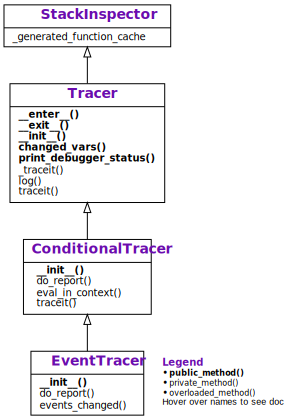

In [74]:
# ignore
display_class_hierarchy(EventTracer,
                        public_methods=[
                            Tracer.__init__,
                            Tracer.__enter__,
                            Tracer.__exit__,
                            Tracer.changed_vars,
                            Tracer.print_debugger_status,
                            ConditionalTracer.__init__,
                            EventTracer.__init__,
                        ],
                        project='debuggingbook')

## Lessons Learned

* Interpreted languages can provide _debugging hooks_ that allow to dynamically control program execution and access program state.
* Tracing can be limited to specific conditions and events:
    * A _breakpoint_ is a condition referring to a particular location in the code.
    * A _watchpoint_ is an event referring to a particular state change.
* Compiled languages allow to _instrument_ code at compile time, injecting code that allows to hand over control to a tracing or debugging tool.

## Next Steps

In the next chapter, we will see how to

* [leverage our tracing infrastructure for interactive debugging](Debugger.ipynb)


## Background

Debugging interfaces like Python `sys.settrace()` are common in all programming languages that provide support for interactive debugging, providing support for executing programs step by step and inspecting program state along the way.

### Low-Level Debugging Interfaces

The first set of interfaces considered takes place at a _low level_, allowing access to _machine level_ features. On Linux and other UNIX-like systems, the [ptrace()](https://en.wikipedia.org/wiki/Ptrace) system call provides a means by which one process (the 'tracer') may observe and control the execution of another process (the 'tracee'), and examine and change the tracee's memory and registers.

`ptrace()` is a low-level interface, which allows to step over individual machine instructions and to read raw memory. In order to map instructions back to original statements and translate memory contents to variable values, compilers can include *debugging information* in the produced binaries, which debuggers then read out during a debugging session.

### High-Level Debugging Interfaces

The second set of interfaces allows to access the program's internals using the concepts of the program – i.e. variables and code locations, as Python does. The [Java Debug Interface](https://docs.oracle.com/javase/8/docs/jdk/api/jpda/jdi/) (JDI) is a _high-level interface_ for implementing a debugger (or tracer) on top of Java. [This introduction to JDI](https://www.baeldung.com/java-debug-interface) shows how to build a debugger using this interface in a few steps.

For JavaScript, Mozilla's [Debugger API](https://developer.mozilla.org/en-US/docs/Tools/Debugger-API) and Google's [chrome.debugger API](https://developer.chrome.com/docs/extensions/reference/debugger/) similarly allow to trace and inspect program execution.

## Exercises


### Exercise 1: Exception Handling

So far, we have only seen execution of lines in individual functions. But if a function raises an exception, we also may want to catch and report this. Right now, an exception is being raised right through our tracer, interrupting the trace. 

In [75]:
def fail() -> float:
    return 2 / 0

In [76]:
with Tracer():
    try:
        fail()
    except Exception:
        pass

Calling fail()
2     return 2 / 0
fail() returns None


Extend the `Tracer` class (or the `EventTracer` subclasses) such that exceptions (event type `'exception'`) are properly traced, too, say as

```
fail() raises ZeroDivisionError: division by zero
```

See the Python documentation for `sys.settrace()`.

**Solution.** Simply extend `print_debugger_status()`:

In [77]:
class Tracer(Tracer):
    def print_debugger_status(self, frame: FrameType, event: str, arg: Any) -> None:
        if event == 'exception':
            exception, value, tb = arg
            self.log(f"{frame.f_code.co_name}() "
                     f"raises {exception.__name__}: {value}")
        else:
            super().print_debugger_status(frame, event, arg)

In [78]:
with Tracer():
    try:
        fail()
    except Exception:
        pass

Calling fail()
2     return 2 / 0
fail() raises ZeroDivisionError: division by zero
fail() returns None


### Exercise 2: Syntax-Based Instrumentation

Adding instrumentation to source code is a complicated business, notably because it is not always easy to determine where and how to instrument. If a Python line starts with 

```python
if condition:
```

where should one insert code to instrument it?

A much more elegant way to instrument code is to add instrumentation _after the code has already been parsed_. Python code, like most other code, is first _parsed_ into an intermediate tree-like structure (called an *abstract syntax tree*, or *AST*). This AST can then be inspected and manipulated, before a second step compiles it into low-level instruction sequences to be executed.

Let us start with an example. Here is an AST resulting from parsing a very simple piece of code:

In [79]:
def foo():  # type: ignore
    ret = 2 * 2
    return ret

In [80]:
source = inspect.getsource(foo)
print_content(source, '.py')

def foo():  # type: ignore
    ret = 2 * 2
    return ret

In [81]:
import ast

In [82]:
from bookutils import show_ast

In [83]:
tree = ast.parse(source)

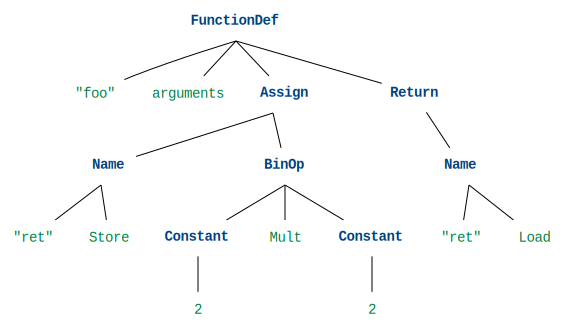

In [84]:
show_ast(tree)

You see that the function `foo()` has a `FunctionDef` node with four children: The function name (`"foo"`), its arguments (`arguments`; currently empty), followed by the statements that make the function body – `Assign` for the assignment, `Return` for the `return` statement.

We obtain and manipulate the AST through the Python `ast` module. The [official Python `ast` reference](http://docs.python.org/3/library/ast) is complete, but a bit brief; the documentation ["Green Tree Snakes - the missing Python AST docs"](https://greentreesnakes.readthedocs.io/en/latest/) provides an excellent introduction.

To instrument the above code, we need to insert a new statement as a child to `FunctionDef` node.

In [85]:
from ast import NodeTransformer, FunctionDef, fix_missing_locations, AST, Module

Here's the code we want to inject:

In [86]:
subtree_to_be_injected: AST = ast.parse("print('entering function')")

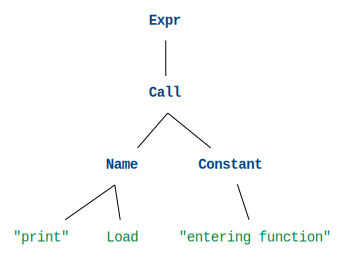

In [87]:
show_ast(subtree_to_be_injected)

The root of an `ast.parse()` tree actually is a `Module` node; we go directly to its child, which is the `Expr` node we want to inject.

In [88]:
subtree_to_be_injected = cast(Module, subtree_to_be_injected).body[0]

To inject the code, we use the `NodeTransformer` class as described in the Python `ast` documentation. We vist all function definitions (`FunctionDef`) and replace them with a new function definition in which the `body` gets an additional child – namely our subtree to be injected.

In [89]:
class InjectPass(NodeTransformer):
    def visit_FunctionDef(self, node: FunctionDef) -> AST:
        return FunctionDef(
            name=node.name,
            args=node.args,
            body=[subtree_to_be_injected] + node.body,
            decorator_list=node.decorator_list,
            returns=node.returns
        )

In [90]:
new_tree = fix_missing_locations(InjectPass().visit(tree))

This is what our new tree looks like:

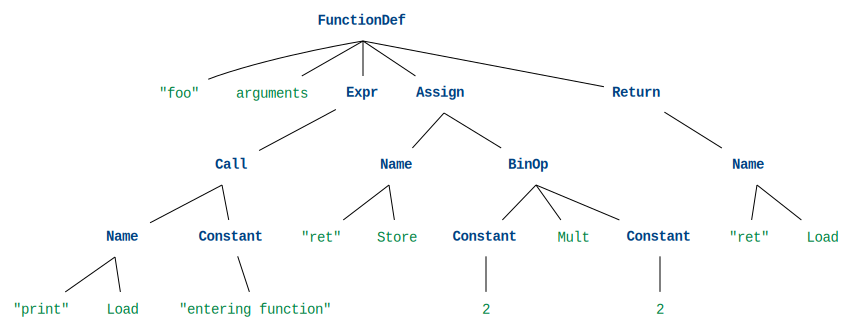

In [91]:
show_ast(new_tree)

This is what the tree looks like when converted back to source code:

In [92]:
new_source = ast.unparse(new_tree)
print_content(new_source, '.py')

def foo():
    print('entering function')
    ret = 2 * 2
    return ret

We can now compile the new source into a function:

In [93]:
exec(new_source)

... and happily invoke our instrumented function.

In [94]:
foo()

entering function


4

Your task is to implement a function `insert_tracer_ast(function, breakpoints)` that works like `insert_tracer()`, above, except that it uses this AST-based mechanism to inject debugging code into the given function.